In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
# https://github.com/tensorflow/docs/blob/3ce5b40191bf8ff8f3663b015815940fbc5907e5/site/en/tutorials/structured_data/time_series.ipynb

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from tensorflow.keras.callbacks import ModelCheckpoint

# os.environ["CUDA_DEVICE_ORDER"] = "GPU"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

import wandb
from wandb.keras import WandbCallback
wandb.init(project="predikcie1krok", name = )

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12866949493069617407
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2752624365173421245
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4867424256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15445846538555578873
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:02:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17996068831728645580
physical_device_desc: "device: XLA_GPU device"
]


In [ ]:
UNIT_COUNT = range(10, 30, 10)

In [ ]:
# zip_path = tf.keras.utils.get_file(
#     origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#     fname='jena_climate_2009_2016.csv.zip',
#     extract=True)
# csv_path, _ = os.path.splitext(zip_path)

In [2]:
df = pickle.load( open( "/home/kriza/programing/clanok/data/picklnute/30min.p", "rb" ) )


In [3]:
# df = pd.read_csv(csv_path)
df.head()


,30m-item56,30m-item57,30m-item58,30m-item59,30m-item60,30m-item61,30m-item62,30m-item63,30m-item64,30m-item65,...,30m-item68,30m-item69,30m-item70,30m-item71,30m-item72,30m-item73,30m-item74,30m-item75,30m-item76,30m-item77
0,9,10,10,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,13,14,14,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,22,22,22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,26,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20,20,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT_BEGIN = 24
TRAIN_SPLIT_END = 15551 - TRAIN_SPLIT_BEGIN
VALID_SPLIT_BEGIN = 15601 - TRAIN_SPLIT_BEGIN
VALID_SPLIT_END = 17463 -TRAIN_SPLIT_BEGIN
tf.random.set_seed(13)


In [6]:
uni_data = df['30m-item61']
# uni_data.index = df['Date Time']
uni_data.head()

0    0
1    0
2    0
3    0
4    0
Name: 30m-item61, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a8cf547b8>],
      dtype=object)

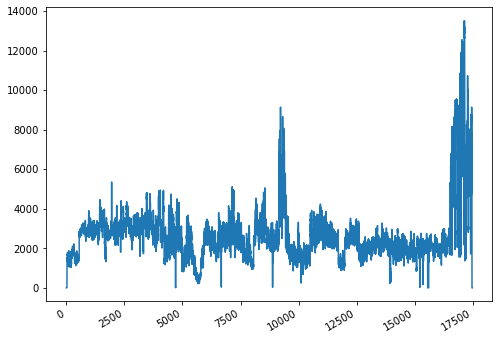

In [7]:
uni_data.plot(subplots=True)


In [8]:
uni_data = uni_data.values
uni_data = uni_data[TRAIN_SPLIT_BEGIN:VALID_SPLIT_END + TRAIN_SPLIT_BEGIN]

In [9]:
uni_train_mean = uni_data[:TRAIN_SPLIT_END].mean()
uni_train_std = uni_data[:TRAIN_SPLIT_END].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std



In [10]:
uni_data.shape

(17439,)

In [11]:
VALID_SPLIT_END

17439

In [37]:
univariate_past_history = 200
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT_END,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, VALID_SPLIT_BEGIN, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [38]:
x_val_uni.shape

(1662, 200, 1)

In [39]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-2.38827874]
 [-1.47825204]
 [-1.38817325]
 [-1.31657217]
 [-1.30848817]
 [-1.31079788]
 [-1.21378996]
 [-1.23226766]
 [-1.13179517]
 [-1.26113907]
 [-1.11447233]
 [-1.0994592 ]
 [-1.03247753]
 [-1.21263511]
 [-1.15489229]
 [-1.07636207]
 [-1.05903923]
 [-1.13525974]
 [-1.03016782]
 [-0.95510217]
 [-0.92623076]
 [-0.91237249]
 [-1.01284498]
 [-0.86386853]
 [-0.88119137]
 [-0.92161134]
 [-0.74607319]
 [-0.88350108]
 [-0.93200504]
 [-0.83384226]
 [-0.92507591]
 [-0.85462968]
 [-0.8592491 ]
 [-0.91814677]
 [-1.07058779]
 [-0.91352734]
 [-0.92392105]
 [-1.03709696]
 [-1.18491856]
 [-1.41011552]
 [-1.49326517]
 [-1.48518117]
 [-1.48056175]
 [-1.48749089]
 [-1.52213657]
 [-1.37316012]
 [-1.34082415]
 [-1.38817325]
 [-1.46092919]
 [-1.53483999]
 [-1.50481373]
 [-1.49557488]
 [-1.47016804]
 [-1.3604567 ]
 [-1.34775328]
 [-1.34890814]
 [-1.30271389]
 [-1.0544198 ]
 [-1.22533852]
 [-1.30155903]
 [-1.25882935]
 [-1.18029913]
 [-1.15027287]
 [-1.03132268]
 [-1.02323

In [40]:
def create_time_steps(length):
  return list(range(-length, 0))

In [41]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/kriza/miniconda3/envs/tf-conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

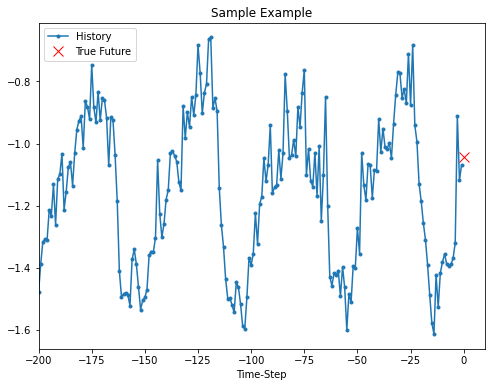

In [42]:
show_plot([x_train_uni[1], y_train_uni[1]], 0, 'Sample Example')


In [43]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/kriza/miniconda3/envs/tf-conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

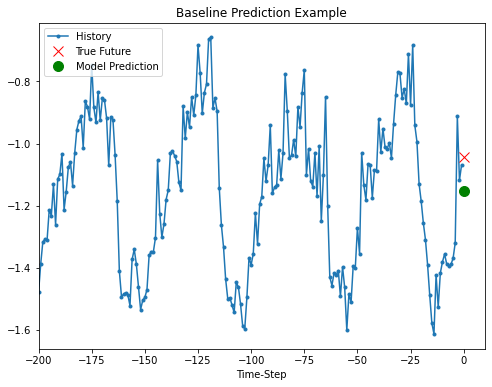

In [44]:
show_plot([x_train_uni[1], y_train_uni[1], baseline(x_train_uni[1])], 0,
           'Baseline Prediction Example')

In [45]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE)

In [50]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(512, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae', metrics='mae')

In [47]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [48]:
x_train_uni.shape

(15327, 200, 1)

In [53]:
EVALUATION_INTERVAL = 200
EPOCHS = 40

ckpt = ModelCheckpoint(filepath="best/best", monitor='val_loss', mode='min',
                       save_best_only = True, save_weights_only=True, verbose = False)

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                    #   steps_per_epoch=int(x_train_uni.shape[0]/BATCH_SIZE),
                      validation_data=val_univariate,
                      callbacks=[ckpt, WandbCallback()]
                    #   , validation_steps=50
                      )

Epoch 1/40
60/60 [==============================] - 12s 192ms/step - loss: 0.2369 - mae: 0.2369 - val_loss: 0.7897 - val_mae: 0.7897
Epoch 2/40
60/60 [==============================] - 11s 190ms/step - loss: 0.1879 - mae: 0.1879 - val_loss: 0.4549 - val_mae: 0.4549
Epoch 3/40
60/60 [==============================] - 11s 189ms/step - loss: 0.1770 - mae: 0.1770 - val_loss: 0.5812 - val_mae: 0.5812
Epoch 4/40
60/60 [==============================] - 11s 191ms/step - loss: 0.1712 - mae: 0.1712 - val_loss: 0.4047 - val_mae: 0.4047
Epoch 5/40
60/60 [==============================] - 11s 191ms/step - loss: 0.1670 - mae: 0.1670 - val_loss: 0.3859 - val_mae: 0.3859
Epoch 6/40
60/60 [==============================] - 11s 191ms/step - loss: 0.1658 - mae: 0.1658 - val_loss: 0.4419 - val_mae: 0.4419
Epoch 7/40
60/60 [==============================] - 12s 192ms/step - loss: 0.1667 - mae: 0.1667 - val_loss: 0.4001 - val_mae: 0.4001
Epoch 8/40
60/60 [==============================] - 12s 192ms/step - 

In [54]:
simple_lstm_model.load_weights("best/best")

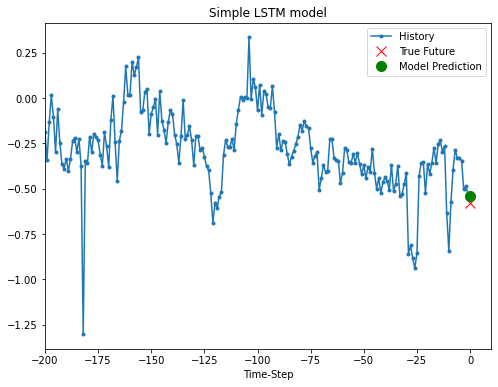

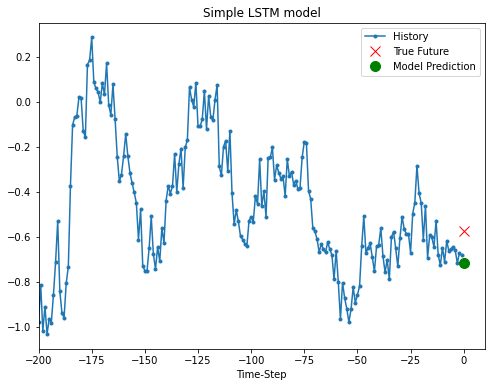

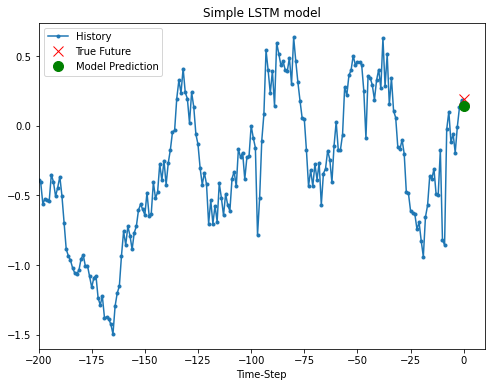

In [55]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [42]:
features_considered = ['30m-item59', '30m-item61', '30m-item66', '30m-item67']


In [45]:
features = df[features_considered]
# features.index = df['Date Time']
features.head()

,30m-item59,30m-item61,30m-item66,30m-item67
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0360142ef0>,
      dtype=object)

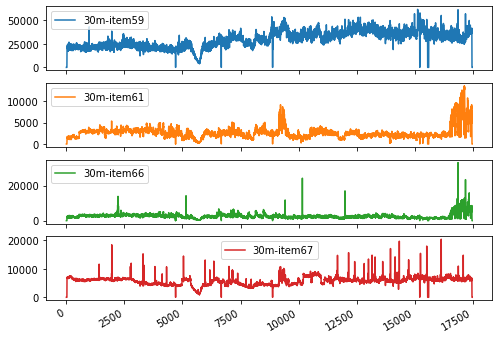

In [46]:
features.plot(subplots=True)


In [47]:
dataset = features.values
dataset


array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       ...,
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1]])

In [48]:
dataset = dataset[TRAIN_SPLIT_BEGIN:VALID_SPLIT_END + TRAIN_SPLIT_BEGIN]
dataset

array([[ 5878,   369,   477,  1933],
       [20090,  1157,  1532,  6774],
       [17654,  1235,  1562,  6777],
       ...,
       [  413,   157,    13,   208],
       [  171,    43,     1,    54],
       [  112,   244,     0,   245]])

In [49]:
data_mean = dataset[:TRAIN_SPLIT_END].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT_END].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [50]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [57]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, -1], 0,
                                                   TRAIN_SPLIT_END, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, -1],
                                               VALID_SPLIT_BEGIN, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [58]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 4)


In [59]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [60]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [61]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [62]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 11ms/step - loss: 0.4292 - val_loss: 0.8202
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.3575 - val_loss: 0.7515
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3121 - val_loss: 0.8204
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2912 - val_loss: 0.8917
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2734 - val_loss: 0.8931
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2608 - val_loss: 0.9318
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2489 - val_loss: 0.9415
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2364 - val_loss: 0.9710
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2258 - val_loss: 0.9596
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2153 - val_loss: 0.

In [63]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

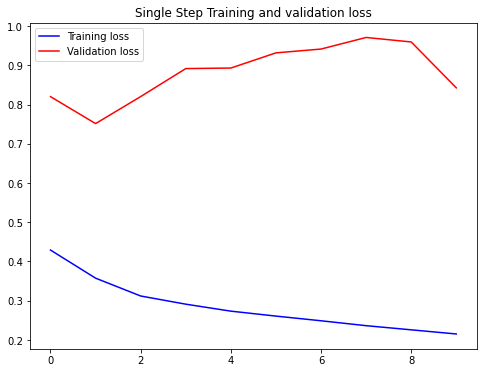

In [64]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

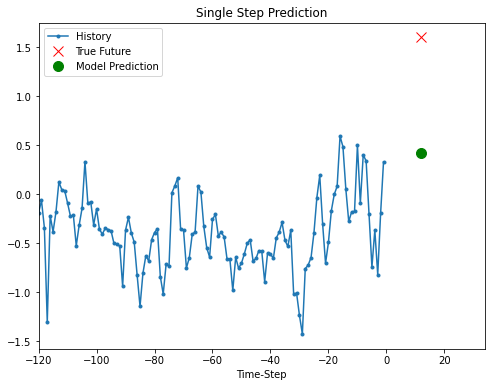

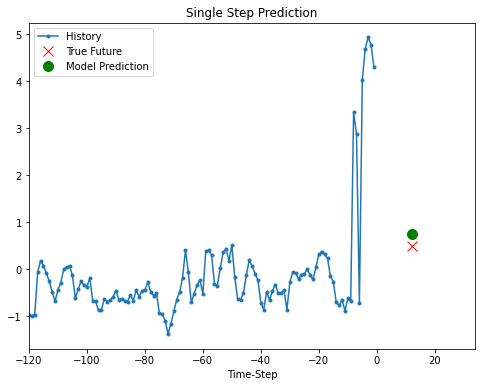

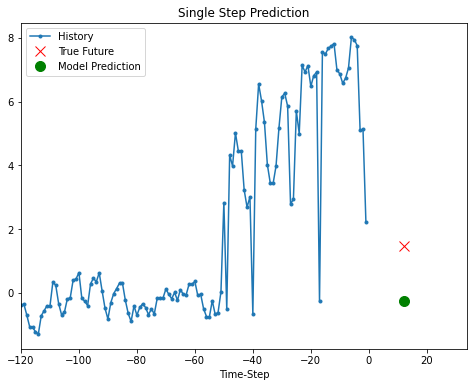

In [65]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [ ]:
#multi step

In [68]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -1], 0,
                                                   TRAIN_SPLIT_END, past_history,
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -1],
                                               VALID_SPLIT_BEGIN, None, past_history,
                                               future_target, STEP)

In [69]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 4)

 Target temperature to predict : (72,)


In [70]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [71]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

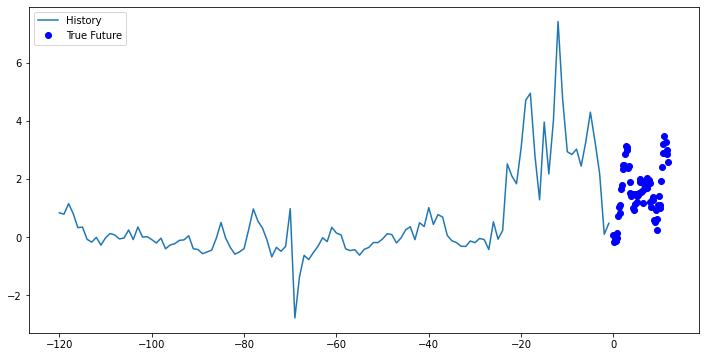

In [72]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [73]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [74]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [75]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 19s 93ms/step - loss: 0.5535 - val_loss: 0.6780
Epoch 2/10
200/200 [==============================] - 18s 92ms/step - loss: 2455.1250 - val_loss: 0.7913
Epoch 3/10
200/200 [==============================] - 18s 92ms/step - loss: 1.2192 - val_loss: 0.9857
Epoch 4/10
200/200 [==============================] - 18s 91ms/step - loss: 8487.2510 - val_loss: 1.0328
Epoch 5/10
200/200 [==============================] - 18s 92ms/step - loss: 0.3149 - val_loss: 0.7192
Epoch 6/10
200/200 [==============================] - 18s 92ms/step - loss: 0.2991 - val_loss: 26.3101
Epoch 7/10
200/200 [==============================] - 18s 91ms/step - loss: 0.2843 - val_loss: 0.5727
Epoch 8/10
200/200 [==============================] - 18s 91ms/step - loss: 65952002048.0000 - val_loss: 0.7670
Epoch 9/10
200/200 [==============================] - 18s 91ms/step - loss: 3583681495040.0000 - val_loss: 0.8498
Epoch 10/10
200/200 [==============================] 

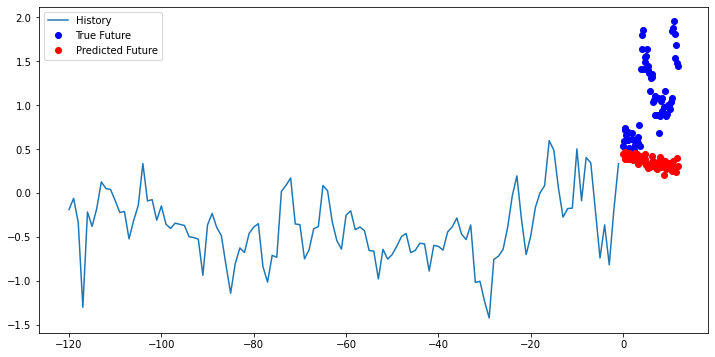

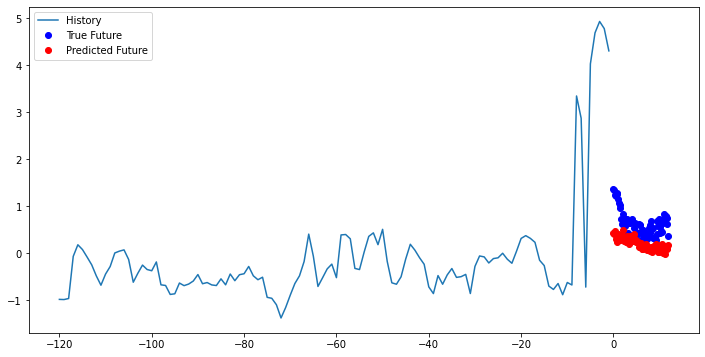

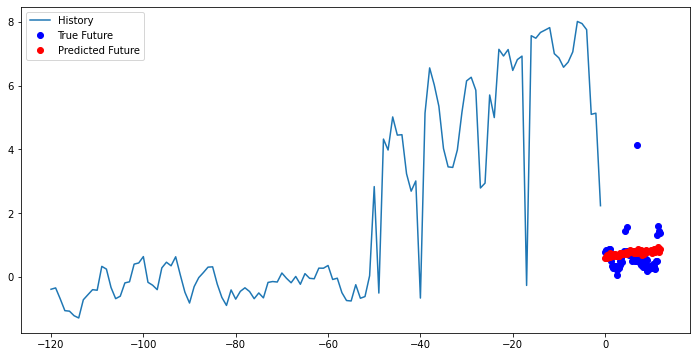

In [76]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])